In [56]:
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [52]:
data = pd.read_csv('tess-table.csv')

data = data[data['tfopwg_disp'] != 'FA' ]
data = data[data['tfopwg_disp'] != 'FP']
data = data[data['tfopwg_disp'] != 'APC']
data.loc[data['tfopwg_disp'] == 'KP', 'tfopwg_disp'] = 0
data.loc[data['tfopwg_disp'] == 'CP', 'tfopwg_disp'] = 1
data.loc[data['tfopwg_disp'] == 'PC', 'tfopwg_disp'] = 1
data['tfopwg_disp'] = data['tfopwg_disp'].astype('int64')
data.head()
data.dropna()
data.dtypes

toi            float64
tid              int64
tfopwg_disp      int64
rastr           object
ra             float64
decstr          object
dec            float64
st_pmra        float64
st_pmdec       float64
pl_tranmid     float64
pl_orbper      float64
pl_trandurh    float64
pl_trandep     float64
pl_rade        float64
pl_insol       float64
pl_eqt         float64
st_tmag        float64
st_dist        float64
st_teff        float64
st_logg        float64
st_rad         float64
toi_created     object
rowupdate       object
dtype: object

In [72]:
X = data.drop(columns=['toi', 'tid', 'toi_created', 'rowupdate', 'decstr', 'rastr'])
y = X.pop('tfopwg_disp').astype('float64')

X.head()

,ra,dec,st_pmra,st_pmdec,pl_tranmid,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_insol,pl_eqt,st_tmag,st_dist,st_teff,st_logg,st_rad
1,122.580465,-5.513852,-4.956,-15.555,2.459988e+06,1.931646,3.166000,1286.000000,11.21540,44464.500000,4045.000000,9.42344,295.862,7070.0,4.03000,2.010000
7,112.752393,-4.463359,0.357,3.399,2.459248e+06,6.998921,3.953000,2840.000000,14.77520,448.744000,1282.000000,8.87759,283.291,6596.0,3.71000,2.700000
9,111.667845,-24.462111,-3.297,4.849,2.459229e+06,1.960028,2.006526,1707.627269,NaN,1063.342296,1456.424653,8.43310,866.147,8868.7,NaN,NaN
10,318.737012,-55.871863,12.641,-16.011,2.458326e+06,1.430370,1.616599,18960.712294,13.18745,1281.240825,1525.904809,12.40690,375.310,5600.0,4.48851,0.890774
12,113.984761,-32.841999,145.102,-134.901,2.459985e+06,2.470498,2.191000,250.000000,1.44656,575.597000,1364.000000,8.23880,52.620,5413.7,4.46000,0.940000


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.2,
                                    random_state=1)

features_num = [
    'ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt',
    'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad'
]
features_cat = []

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),ayers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=100,
    #callbacks=[early_stopping]
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - binary_accuracy: 0.9295 - loss: 0.1868 - val_binary_accuracy: 0.9209 - val_loss: 0.2348
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - binary_accuracy: 0.9270 - loss: 0.1884 - val_binary_accuracy: 0.9209 - val_loss: 0.2176
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - binary_accuracy: 0.9277 - loss: 0.1854 - val_binary_accuracy: 0.9218 - val_loss: 0.2356
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - binary_accuracy: 0.9287 - loss: 0.1890 - val_binary_accuracy: 0.9201 - val_loss: 0.2305
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - binary_accuracy: 0.9382 - loss: 0.1746 - val_binary_accuracy: 0.9251 - val_loss: 0.2184
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - binary_accuracy: 0.9346 - loss: 0.1706 - val_binary_accuracy: 0.9193 - val_loss: 0.2151
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - binary_accuracy: 0.9352 - loss: 0.1737 - val_binary_accuracy: 0.9251 - val_loss: 0.2176
Epoch 

<Axes: title={'center': 'Accuracy'}>

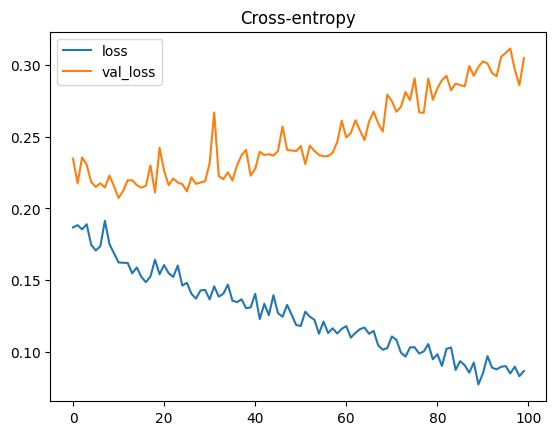

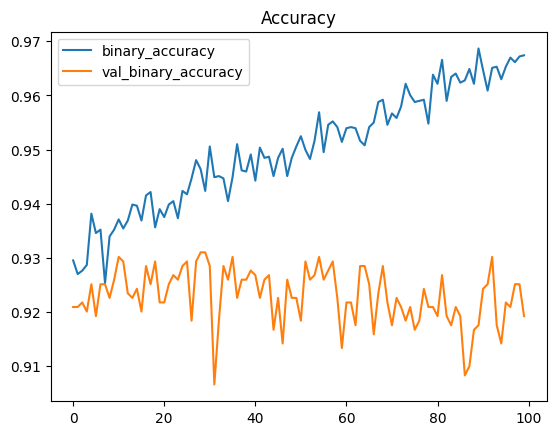

In [78]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [76]:
model.save('testmodel-1.keras')